In [1]:
%load_ext autoreload
%autoreload 2

%load_ext dotenv
%dotenv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from collections import OrderedDict

import os
from pathlib import Path

from jax import lax, vmap
import jax.numpy as jnp
import jax.random as jr
import numpy as onp

from tqdm.notebook import tqdm, trange

from scipy.cluster.hierarchy import fcluster, ward
from scipy.spatial.distance import pdist, squareform

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelBinarizer

import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet  as cc  # used for maximally distinct categorical colors

from dtd.data import load_wiltschko22_data
from dtd.viz import draw_drug_class_boxes, set_syllable_cluster_ticks, set_time_within_session_ticks

In [3]:
DATA_DIR = Path(os.environ['DATA_DIR'])
data_path = DATA_DIR/'syllable_binned_1min.npz'

data, batch_axes, event_axes, metadata = load_wiltschko22_data(data_path)
event_ndims = len(event_axes)
print(f"data: shape={data.shape}, dtype={data.dtype}, event_ndims={event_ndims}")

data: shape=(500, 20, 90), dtype=int32, event_ndims=1


In [127]:
from run import get_labels, fit_and_transform_model

In [128]:
y, label_encoder = get_labels(metadata['session'], target_name='drug')
print(f"{y.shape=}")
print(label_encoder.classes_)

y.shape=(500,)
['ALPR' 'DIAZ' 'BUPR' 'PHEN' 'CHKO' 'CLOZ' 'HALO' 'RISP' 'ATOM' 'VENL'
 'CITA' 'FLUO' 'METH' 'MTPH' 'MODA' 'CTRL']


In [37]:
model_name = 'dtd'
model_dim = 16
model_params = dict(event_ndims=event_ndims, n_epochs=500, n_inits=5, key=0)

features = fit_and_transform_model(data, model_name, model_dim, model_params)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Text(0.5, 1.0, 'session factor weights, k1=16')

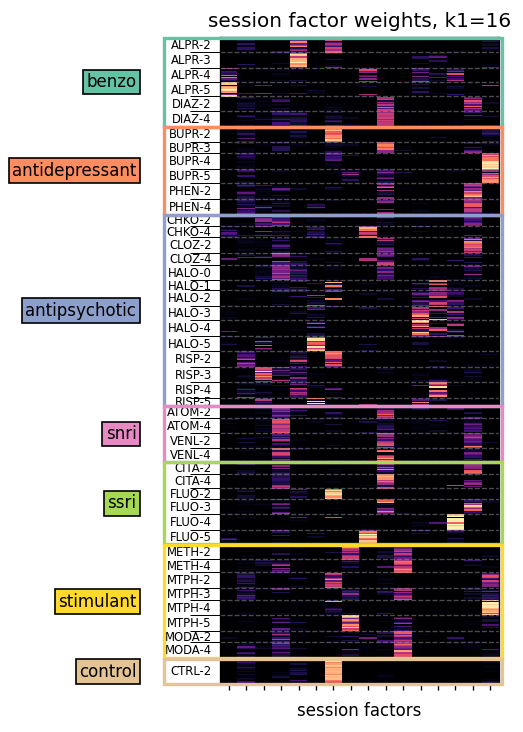

In [51]:
d, k = features.shape

perm = onp.arange(k)

# ------------------------------------------------------------------------------------------------

plt.figure(figsize=(3,7), dpi=120)
ax = plt.gca()

ax.imshow(features[:,perm], cmap='magma', clim=(0,1), interpolation='none', aspect='auto',)

# Label axes
ax.set_xticks(range(features.shape[-1]))
ax.set_xticklabels([])
ax.set_xlabel('session factors')

drug_dose_labels, dose_lb = get_labels(metadata['session'], 'dose')
drug_dose_labels = dose_lb.inverse_transform(drug_dose_labels)
session_drug_class, class_lb = get_labels(metadata['session'], 'class')
session_drug_class = class_lb.inverse_transform(session_drug_class)

set_syllable_cluster_ticks(drug_dose_labels, axis='y')
draw_drug_class_boxes(session_drug_class, bbox_x=-0.2, bbox_w=1.21, ax=ax)

ax.set_title(f'session factor weights, k1={k}', fontsize='large')

## Verify linear regression

In [15]:
from run import get_labels

labels, label_encoder, label_binarizer = get_labels(metadata['session'], target_name='drug')

y = label_encoder.transform(labels)
print(f"{y.shape=}")
print(label_encoder.classes_)

y.shape=(500,)
['ALPR' 'DIAZ' 'BUPR' 'PHEN' 'CHKO' 'CLOZ' 'HALO' 'RISP' 'ATOM' 'VENL'
 'CITA' 'FLUO' 'METH' 'MTPH' 'MODA' 'CTRL']


In [6]:
# wiltschko et al 2020
X = data.sum(axis=1) / (data.sum(axis=1)).sum(axis=-1, keepdims=True)

In [ ]:
from run import train_and_eval_one

n_splits = 100
test_frac = 0.1
seed = 40
splits = StratifiedShuffleSplit(
        n_splits=n_splits, test_size=test_frac, random_state=seed
).split(X, y)

n_test = len(next(splits)[-1])
n_labels = len(label_encoder.classes_)

all_y_true = onp.zeros((n_splits, n_test), dtype=int)
all_y_pred = onp.zeros((n_splits, n_test), dtype=int)
all_scores = onp.zeros((n_splits, n_test, n_labels))
all_cms = onp.zeros((n_splits, n_labels, n_labels))
all_f1s = onp.zeros((n_splits, n_labels))
for i_split, (train_idxs, test_idxs) in enumerate(tqdm(splits, total=n_splits)):
    y_true, y_pred, scores, cm, f1 = train_and_eval_one(
            X[train_idxs], y[train_idxs], X[test_idxs], y[test_idxs],
    )

    all_y_true[i_split] = y_true
    all_y_pred[i_split] = y_pred
    all_scores[i_split] = scores
    all_cms[i_split] = cm
    all_f1s[i_split] = f1

    # Normalize confusion matrices over total true instances, a "precision" confusion matrix
    avg_cm = onp.asarray(all_cms.sum(axis=0), dtype=float)
    avg_cm /= avg_cm.sum(axis=0, keepdims=True)  # shape (n_labels, n_labels)

    avg_f1 = all_f1s.mean(axis=0)  # shape (n_labels)


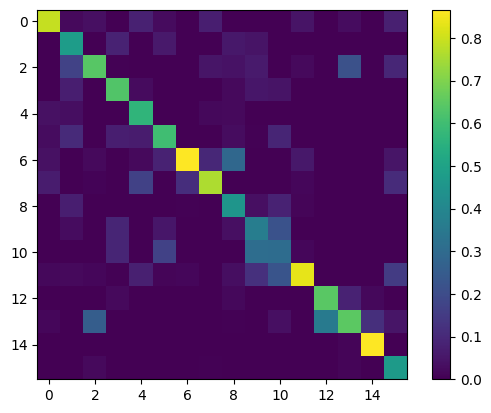

In [14]:
im = plt.imshow(avg_cm)
plt.colorbar(im)

In [19]:
all_scores.shape

(100, 50, 16)

In [20]:
all_y_true_onehot = label_binarizer.transform(
    label_encoder.inverse_transform(all_y_true.ravel())
).reshape(n_splits, n_test, -1)
all_y_true_onehot.shape

(100, 50, 16)

In [21]:
# ---------------------------------------------------------------------
# Compute precision and recall metrics
# ---------------------------------------------------------------------

# Per-class
precision_by_class, recall_by_class = dict(), dict()
for i, lbl in enumerate(label_encoder.classes_):
    precision_by_class[lbl], recall_by_class[lbl], _ \
            = precision_recall_curve(all_y_true_onehot[...,i].ravel(), all_scores[...,i].ravel())

# "Micro-average" over all classes
avg_precision, avg_recall, _ = precision_recall_curve(
    all_y_true_onehot.ravel(), all_scores.ravel()
)  # shape (n_thresh,) where n_thresh = np.unique(scores)

0.6023021925990671


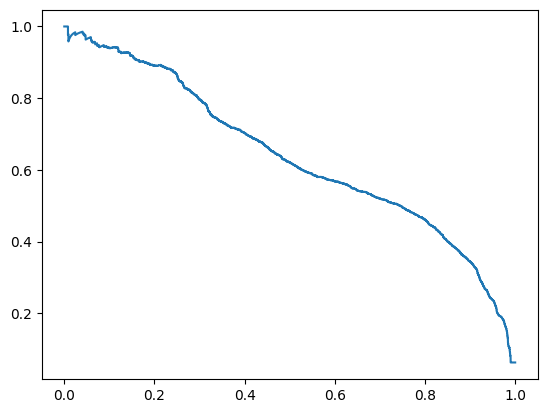

In [24]:
plt.plot(avg_recall, avg_precision)
print(avg_f1.mean())

In [100]:
print(clf.estimators_[0].predict(X_test))
print(true_y_test[4])
print(pred_y_test[4])

[0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0]


In [77]:
len(onp.nonzero(true_y_test)[1]), len(onp.nonzero(pred_y_test)[1])

(50, 126)

In [89]:
y_str = lb.inverse_transform(y)
model = LogisticRegression(penalty='l2', C=C, solver='lbfgs', multi_class='ovr', class_weight='balanced')
model.fit(X_train, y_str[train_idxs])
y_pred_refr = model.predict(X_test)

/scratch/users/eyz/miniconda3/envs/dtd/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
